In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
file1 = open('2006rts1.txt')
file2 = open('rts2.txt')

In [3]:
file_text_1 = file1.read()
file_text_2 = file2.read()

In [4]:
y_1 = np.array([float(x) for x in file_text_1.split()])
y_2 = np.array([float(x) for x in file_text_2.split()])

In [5]:
(len(y_2))

178

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [6]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [7]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample);
    plot_acf(sample);

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [8]:
def claculate_metrics_model(y, y_pred, p, q, weight, window):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
def AR(p, y):
    
    df_temp = df = pd.DataFrame(y, columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    train_size = (int)(0.8 * df_temp.shape[0])

    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    print(f"The RMSE is : {RMSE} \tValue of p : {p}")
    return df_train_2,df_test,theta,intercept,RMSE

In [11]:
def MA(q, res_real):
    
    res = res_real.copy()
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)
    

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
        

    res_train_2['Predicted_Values'] = X_train.dot(theta) + intercept
    
    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(theta) + intercept
    res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

In [ ]:
a = [1,2,3,4,5]
b = [2,3]
intercept_a = 1
intercept_b = 2

In [ ]:
def coef_model_df(a, b, intercept_a, intercept_b):
    

## ARMA

In [12]:
calculate_metrics_sample(y_1)

{'series': 'Y',
 'observations': 248,
 'mode': 1190.34,
 'mean': 1545.9118951612907,
 'median': 1552.115,
 'variation': 24453.166410563863,
 'skewness': 0.1420579833187732,
 'kurtosis': -0.44372227972289036,
 'jarque-bera': 3.000356221871671,
 'probability': 0.22309042176581806}

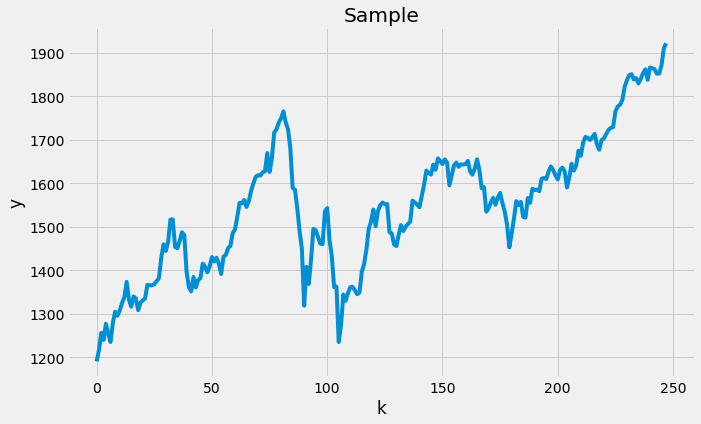

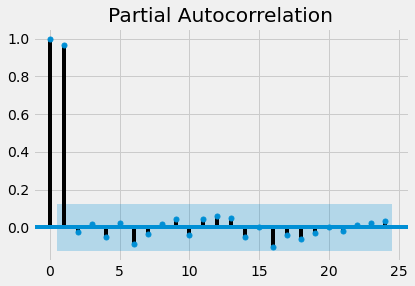

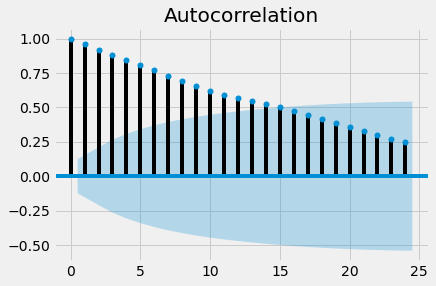

In [13]:
calculate_metrics_sample(y_1)
show_plots(y_1)

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [14]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [15]:
weight, window, p= 'simple', 5, 14

In [16]:
df_train, df_test, theta, intercept, RMSE = AR(p, y_1)

The RMSE is : 22.922015332263054 	Value of p : 14


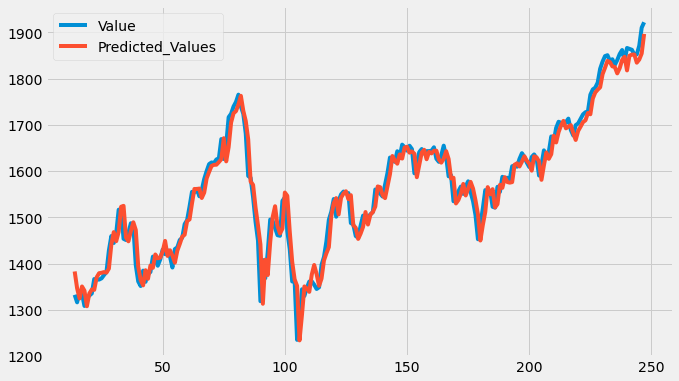

In [17]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [18]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values
res.head()

,Residuals
14,-50.554209
15,-30.411344
16,15.284405
17,-15.472794
18,-33.152286


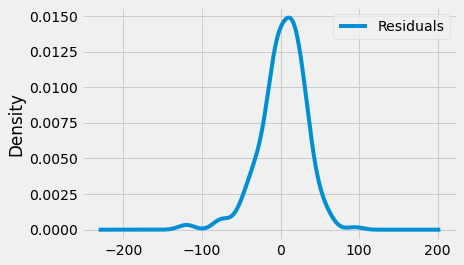

In [19]:
res.plot(kind='kde')

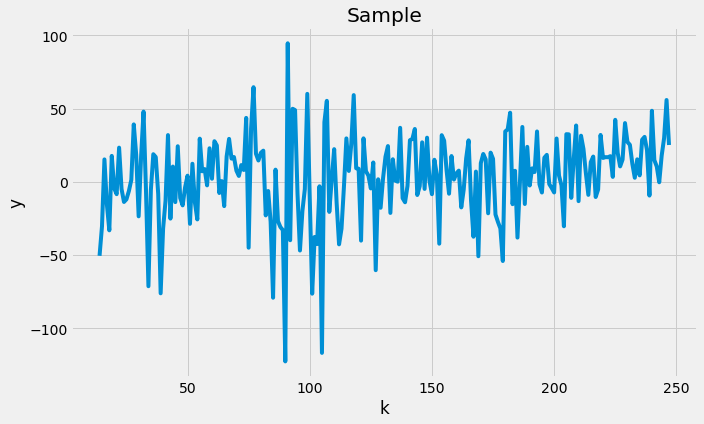

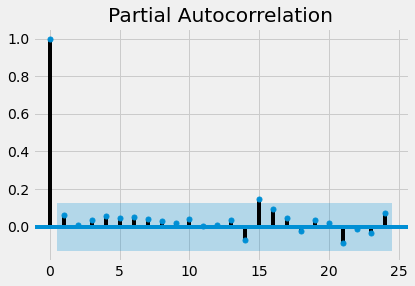

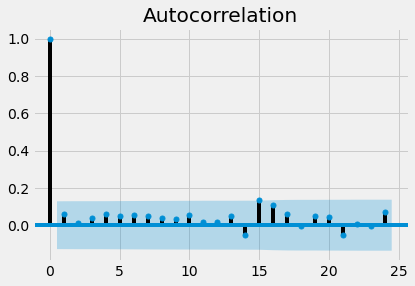

In [20]:
show_plots(res['Residuals'])

## Build MA simple, n=5

In [21]:
def weight_MA(q, res, weight, window):
    
    if weight=='simple':
        wma = res.rolling(window=window).mean()
        
    elif weight== 'exponential':
        wma = res.ewm(span=window).mean()
    
    else:
        pass
        
    return MA(q, wma)

The RMSE is : 5.668457387772744 , Value of q :  1


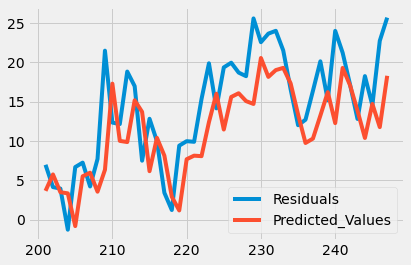

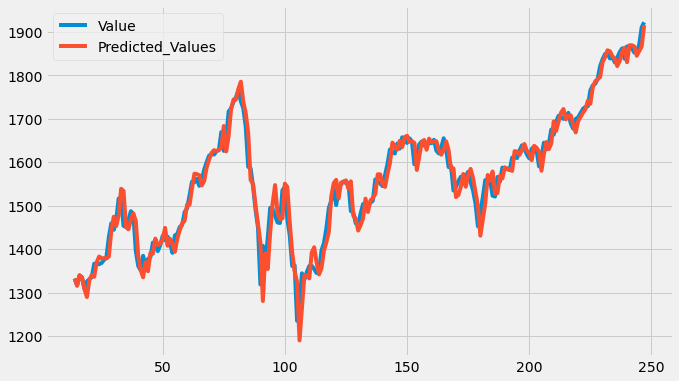

In [22]:
q = 1
res_train, res_test,theta,intercept,RMSE = weight_MA(q, res, weight=weight, window=window)

res_c = pd.concat([res_train,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c['Predicted_Values'][:window] = df_c['Value'][:window]
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [23]:
metrics = claculate_metrics_model(df_c['Value'], df_c['Predicted_Values'], p, q, weight, window)
models_metrics = models_metrics.append(metrics)
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson
0,"ARMA((14, 1)) simple:5",0.9585212550777782,204937.39797872223,2891.927601570259,2.0727842187615106


## Build MA simple, n=10

The RMSE is : 2.541078369946758 , Value of q :  1


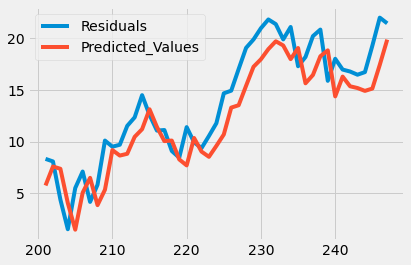

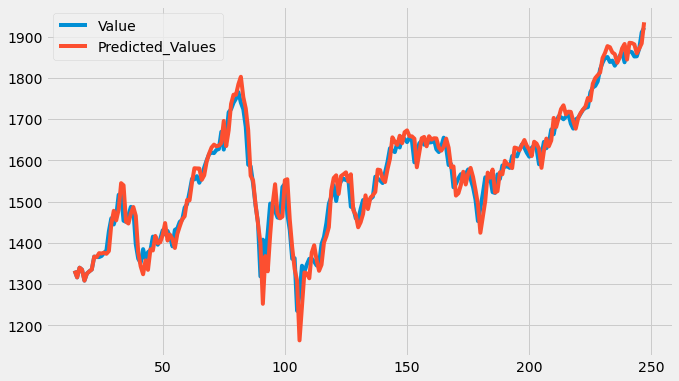

In [24]:
q, window = 1, 10
res_train, res_test,theta,intercept,RMSE = weight_MA(q, res, weight=weight, window=window)

res_c = pd.concat([res_train,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c['Predicted_Values'][:window] = df_c['Value'][:window]
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [25]:
metrics = claculate_metrics_model(df_c['Value'], df_c['Predicted_Values'], p, q, weight, window)
models_metrics = models_metrics.append(metrics)
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson
0,"ARMA((14, 1)) simple:5",0.9585212550777782,204937.39797872223,2891.927601570259,2.0727842187615106
0,"ARMA((14, 1)) simple:10",0.9507171106847369,243495.96691225978,2932.2682240606737,1.882827563359674


## Build MA ___ EMA, n=5

The RMSE is : 7.7990817455646235 , Value of q :  1


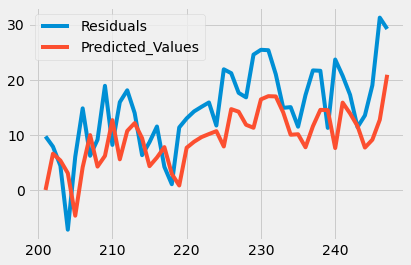

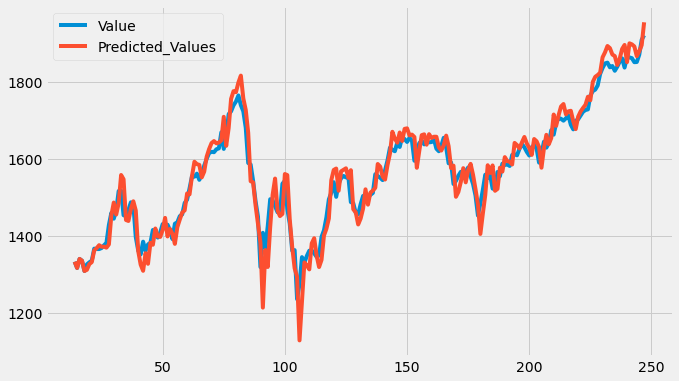

In [26]:
q, window, weight = 1, 5, 'exponential'
res_train, res_test,theta,intercept,RMSE = weight_MA(q, res, weight=weight, window=window)

res_c = pd.concat([res_train,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c['Predicted_Values'][:window] = df_c['Value'][:window]
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [27]:
metrics = claculate_metrics_model(df_c['Value'], df_c['Predicted_Values'], p, q, weight, window)
models_metrics = models_metrics.append(metrics)
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson
0,"ARMA((14, 1)) simple:5",0.9585212550777782,204937.39797872223,2891.927601570259,2.0727842187615106
0,"ARMA((14, 1)) simple:10",0.9507171106847369,243495.96691225978,2932.2682240606737,1.882827563359674
0,"ARMA((14, 1)) exponential:5",0.9342766278518437,324724.7933775929,2999.6315952362957,1.748888039233404


## Build MA __ EMA, n=10

The RMSE is : 4.4760085104625045 , Value of q :  1


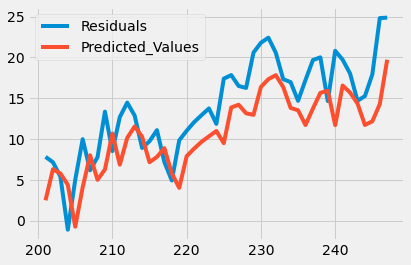

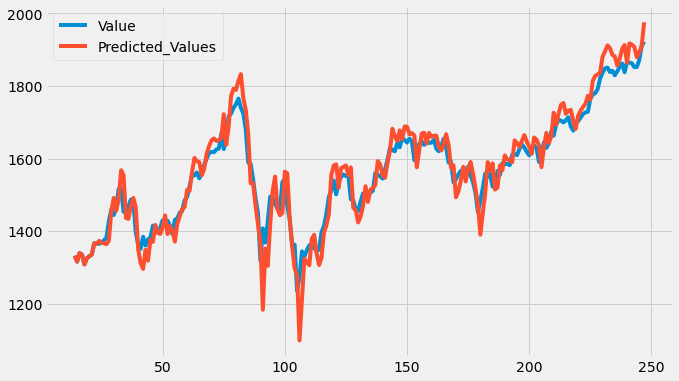

In [28]:
q, window, weight = 1, 10, 'exponential'
res_train, res_test,theta,intercept,RMSE = weight_MA(q, res, weight=weight, window=window)

res_c = pd.concat([res_train,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c['Predicted_Values'][:window] = df_c['Value'][:window]
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [29]:
metrics = claculate_metrics_model(df_c['Value'], df_c['Predicted_Values'], p, q, weight, window)
models_metrics = models_metrics.append(metrics)
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson
0,"ARMA((14, 1)) simple:5",0.9585212550777782,204937.39797872223,2891.927601570259,2.0727842187615106
0,"ARMA((14, 1)) simple:10",0.9507171106847369,243495.96691225978,2932.2682240606737,1.882827563359674
0,"ARMA((14, 1)) exponential:5",0.9342766278518437,324724.7933775929,2999.6315952362957,1.748888039233404
0,"ARMA((14, 1)) exponential:10",0.9121054837966305,434267.56236462126,3067.6513735464396,1.4943718104278916


# ARMA is built by predicted values

In [89]:
df_train, df_test, theta, intercept, RMSE = AR(p, y_1)

The RMSE is : 22.922015332263054 	Value of p : 14


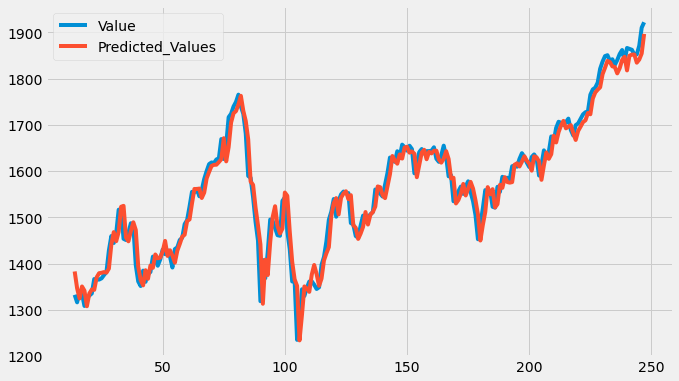

In [90]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [91]:
res = pd.DataFrame()
res['Residuals'] = df_c.Predicted_Values
res.head()

,Residuals
14,1382.824209
15,1346.371344
16,1324.285595
17,1350.322794
18,1341.282286


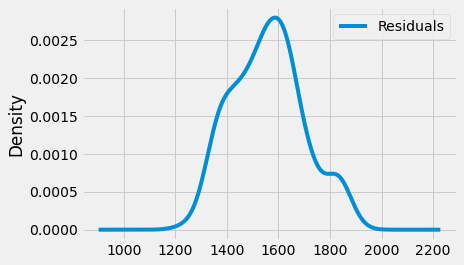

In [92]:
res.plot(kind='kde')

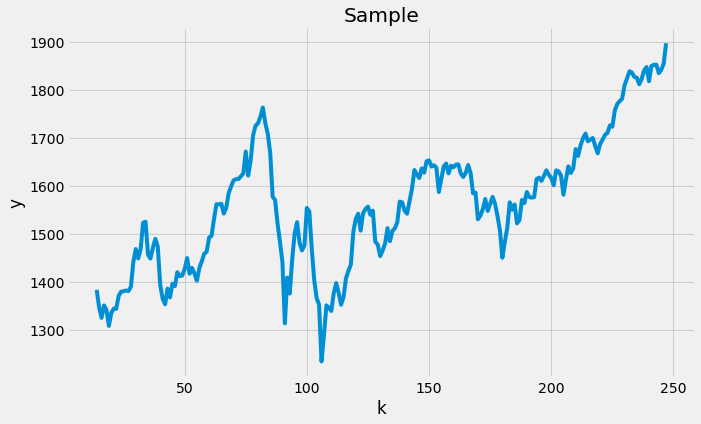

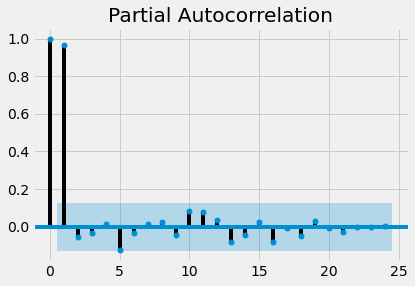

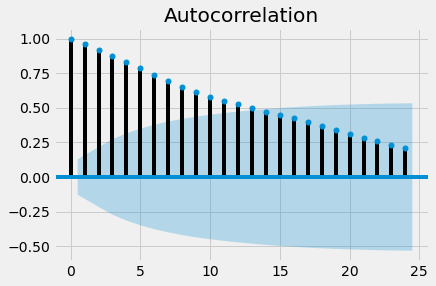

In [93]:
show_plots(res['Residuals'])

## Build MA simple, n=5

In [94]:
models_metrics_pred = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

The RMSE is : 5.783042585066521 , Value of q :  14


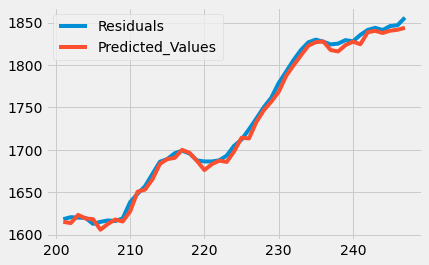

In [95]:
q, window, weight = 14, 5, 'simple'
res_train, res_test,theta,intercept,RMSE = weight_MA(q, res, weight=weight, window=window)

res_c = pd.concat([res_train,res_test])

In [105]:
pred_value = df_c.Predicted_Values
df_c.Predicted_Values += res_c.Predicted_Values 

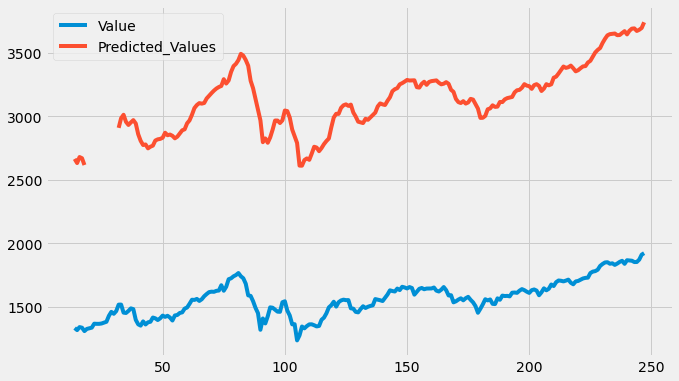

In [108]:
df_c['Predicted_Values'][:window] = 2*df_c['Value'][:window]

In [109]:
df_c['Predicted_Values'] -= df_c.Value - pred_value

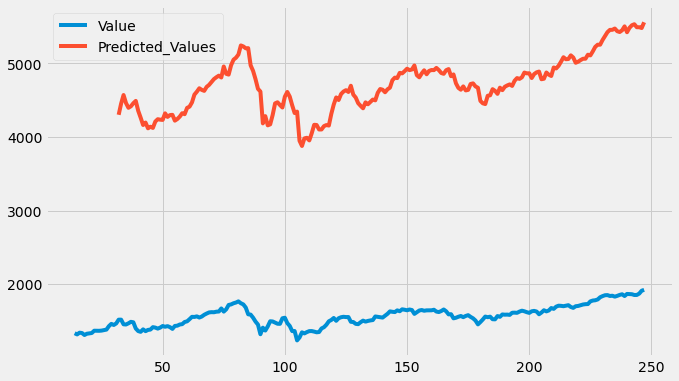

In [110]:
df_c[['Value','Predicted_Values']].plot(figsize=[10,6])

In [80]:
df_c.Predicted_Values

14     1332.270000
15     1315.960000
16     1339.570000
17     1334.850000
18     1308.130000
          ...     
243    1840.278596
244    1837.775119
245    1840.443947
246    1841.540353
247    1843.893649
Name: Predicted_Values, Length: 234, dtype: float64

In [81]:
df_c.Value

14     1332.27
15     1315.96
16     1339.57
17     1334.85
18     1308.13
        ...   
243    1851.96
244    1852.39
245    1871.18
246    1910.28
247    1921.92
Name: Value, Length: 234, dtype: float64

In [79]:
metrics = claculate_metrics_model(df_c['Value'], df_c['Predicted_Values'], p, q, weight, window)
models_metrics_pred = models_metrics_pred.append(metrics)
models_metrics_pred

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## ARMA(0,1)

In [19]:
model_arma_0_1 = ARIMA(ma_sample, order=(0, 0, 1))
model_arma_0_1 = model_arma_0_1.fit(method='mle')

In [20]:
print(model_arma_0_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(0, 1)   Log Likelihood                 -19.449
Method:                           mle   S.D. of innovations              0.294
Date:                Fri, 09 Oct 2020   AIC                             44.898
Time:                        19:23:44   BIC                             52.714
Sample:                             0   HQIC                            48.062
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.030      0.028      0.978      -0.058       0.059
ma.L1.y        0.0140      0.098      0.144      0.886      -0.177       0.205
                                    Roots           

In [21]:
model_arma_0_1_metric = {}
model_arma_0_1_metric['r_squared'] = r2_score(sample, model_arma_0_1.predict())
model_arma_0_1_metric['sum_squared_resid'] = sum(model_arma_0_1.resid**2)
model_arma_0_1_metric['aic'] = model_arma_0_1.aic
model_arma_0_1_metric['durbin_watson'] = durbin_watson(model_arma_0_1.resid)

In [22]:
model_arma_0_1_metric

{'r_squared': 0.007773736314529711,
 'sum_squared_resid': 8.63890805335977,
 'aic': 44.89849210295657,
 'durbin_watson': 1.996220205282663}

In [23]:
ma_coef = model_arma_0_1.maparams
ma_coef

array([0.01403181])

In [24]:
model_arma_0_1.params

const      0.000831
ma.L1.y    0.014032
dtype: float64